# Analyses of available gene expression data sets

In order to model the regulatory space we will use a combination of protein-protein interaction data, bulk and single-cell gene expression data. In this notebook, we provide initial, exploratory data analyses of the existing data sets. The final goal of the analyses is to identify an applicable gene expression data set that can be used to guide the derivation of the regulatory space spanned by a set of regulators that include the gene targets of the perturbations of the imaging dataset and additional important genes.

---

## 0. Environmental setup

In [34]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import mygene
import copy
import venn
from networkx.algorithms.approximation import steinertree

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
def plot_target_intersection_size(adata, targets, figsize=[10, 8], title=""):
    targets = set(targets)
    intersection_size = []
    sorted_var_data = adata.var.sort_values("dispersions_norm", ascending=False)
    for i in range(len(adata.var.index)):
        mvg = set(list(sorted_var_data.index)[:i])
        intersection_size.append(len(mvg.intersection(targets)))
    data = pd.DataFrame.from_dict(
        {
            "MVG set size": list(range(len(intersection_size))),
            "Intersection size with targets": intersection_size,
        }
    )
    ax = sns.lineplot(data=data, x="MVG set size", y="Intersection size with targets")
    ax.set_title(title)
    plt.show()

<IPython.core.display.Javascript object>

In [3]:
def plot_mvgs_intersection_size(adata_1, adata_2, figsize=[10, 8], title=""):
    intersection_size = []
    sorted_var_data_1 = adata_1.var.sort_values("dispersions_norm", ascending=False)
    sorted_var_data_2 = adata_2.var.sort_values("dispersions_norm", ascending=False)
    for i in range(min(len(adata_1.var.index), len(adata_2.var.index))):
        mvg_1 = set(list(sorted_var_data_1.index)[:i])
        mvg_2 = set(list(sorted_var_data_2.index)[:i])
        intersection_size.append(len(mvg_1.intersection(mvg_2)))
    data = pd.DataFrame.from_dict(
        {
            "MVG set size": list(range(len(intersection_size))),
            "Intersection size": intersection_size,
        }
    )
    ax = sns.lineplot(data=data, x="MVG set size", y="Intersection size")
    ax.set_title(title)
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
def plot_dispersion_mvg(adata, title="", logx=False):
    sorted_var_data = adata.var.sort_values("dispersions_norm", ascending=False)
    data = pd.DataFrame.from_dict(
        {
            "dispersions_norm": np.array(sorted_var_data.dispersions_norm),
            "MVG set size": list(range(len(sorted_var_data))),
        }
    )
    ax = sns.lineplot(data=data, x="MVG set size", y="dispersions_norm")
    ax.set_title(title)
    if logx:
        ax.set_xscale("log")
    plt.show()

<IPython.core.display.Javascript object>

---

## 1. MerFISH data (Xia et al. 2019)

The first data set that we analyze is a single-gene expression data set from Xia et al (2019). The authors measured the expression of 12,903 genes for 1,368 U2OS cells using MerFISH.

### 1a. Read in data

In [5]:
merfish_adata = sc.read_csv("../../data/gex/pnas.1912459116.sd12.csv").transpose()
merfish_adata

AnnData object with n_obs × n_vars = 1368 × 12903

<IPython.core.display.Javascript object>

### 1b. Preprocessing

We run a standard preprocessing pipeline on the raw data to filter out genes that are expressed in less than 10 cells and cells that do not express at least 500 genes. This is done in order to exclude samples and features with little support that constitute outliers.

In [6]:
merfish_adata.var["n_cells_per_gene"] = np.sum(
    (np.array(merfish_adata.to_df()) > 0), axis=0
)
merfish_adata.obs["n_genes_per_cell"] = np.sum(
    (np.array(merfish_adata.to_df())) > 0, axis=1
)

<IPython.core.display.Javascript object>

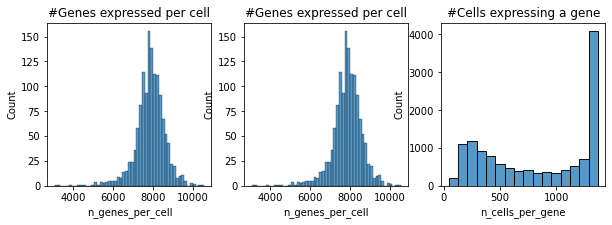

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(1, 3, figsize=[10, 3])
ax = ax.flatten()
sns.histplot(merfish_adata.obs["n_genes_per_cell"], ax=ax[0])
ax[0].set_title("#Genes expressed per cell")

sns.histplot(merfish_adata.obs["n_genes_per_cell"], ax=ax[1])
ax[1].set_title("#Genes expressed per cell")

sns.histplot(merfish_adata.var["n_cells_per_gene"], ax=ax[2])
ax[2].set_title("#Cells expressing a gene")
plt.show()

Using those parameters no sample of gene gets filtered out. We finally normalize the data to account for the variable sequencing depth for the individual cells and log-transform the data.

In [8]:
sc.pp.normalize_total(merfish_adata, target_sum=1e6)
sc.pp.log1p(merfish_adata)

<IPython.core.display.Javascript object>

Next, we compute the normalized variance of the individual genes as described in Stuart et al. (2019).

In [9]:
sc.pp.highly_variable_genes(
    merfish_adata, flavor="seurat", n_top_genes=merfish_adata.n_vars
)

<IPython.core.display.Javascript object>

In [10]:
merfish_adata.var

,n_cells_per_gene,highly_variable,means,dispersions,dispersions_norm
A1CF,188,True,0.962251,2.467203,-0.624936
A2M,819,True,3.091791,4.901508,4.166767
A2ML1,134,True,0.741775,2.451442,-0.737021
A4GALT,1128,True,3.261995,2.903776,-0.018543
AACS,1368,True,5.408722,3.210440,-0.645476
...,...,...,...,...,...
ZYG11A,109,True,0.676425,2.887991,3.619676
ZYG11B,1366,True,5.144206,3.159242,-0.493262
ZZEF1,1345,True,4.156298,2.676982,-1.082418
ZZZ3,1368,True,5.779430,3.289328,-0.508418


<IPython.core.display.Javascript object>

---

## 2. FUCCI scRNA-seq data (Mahdessian et al. 2021)

The second data set consists of 1,152 U2OS FUCCI cells that were sorted by FACS and sequenced at single-cell resolution using SMART-seq2 chemistry. In total 42'728 genes were captured.

### 2a. Read in data

In [39]:
fucci_adata = sc.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/gex/GSE146773_Counts.csv"
)
fucci_adata

AnnData object with n_obs × n_vars = 1152 × 42728

<IPython.core.display.Javascript object>

Before we can continue we need to translate the Ensemble IDs to their respective gene names for consistency purposes.

In [6]:
mg = mygene.MyGeneInfo()
fucci_gene_list = list(fucci_adata.var.index)
fucci_query_results = mg.querymany(
    fucci_gene_list, scopes="ensembl.gene", fields="symbol", species="human"
)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

<IPython.core.display.Javascript object>

In [7]:
fucci_gene_symbs = []
fucci_gene_ensid = []
missing_duplicate_symbs = []
for query_result in fucci_query_results:
    try:
        fucci_gene_symbs.append(query_result["symbol"])
        fucci_gene_ensid.append(query_result["query"])
    except KeyError:
        missing_duplicate_symbs.append(query_result["query"])
len(missing_duplicate_symbs)

6803

<IPython.core.display.Javascript object>

There are 6803 ensemble ID that were not found in the reference data set. We will remove those 6803 genes from our analyses.

In [8]:
fucci_adata = fucci_adata[:, fucci_gene_ensid]


View of AnnData object with n_obs × n_vars = 1152 × 35925

<IPython.core.display.Javascript object>

In [22]:
fucci_adata.var["gene_symbol"] = fucci_gene_symbs

<IPython.core.display.Javascript object>

We are left with 35'925 genes.

### 2b. Preprocessing

We will now run a similar preprocessing pipeline as for the previously described MerFISH data set.

In [43]:
fucci_adata.var["n_cells_per_gene"] = np.sum(
    (np.array(fucci_adata.to_df()) > 0), axis=0
)
fucci_adata.obs["n_genes_per_cell"] = np.sum(
    (np.array(fucci_adata.to_df())) > 0, axis=1
)

<IPython.core.display.Javascript object>

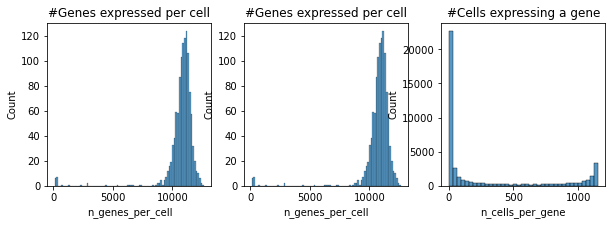

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(1, 3, figsize=[10, 3])
ax = ax.flatten()
sns.histplot(fucci_adata.obs["n_genes_per_cell"], ax=ax[0])
ax[0].set_title("#Genes expressed per cell")

sns.histplot(fucci_adata.obs["n_genes_per_cell"], ax=ax[1])
ax[1].set_title("#Genes expressed per cell")

sns.histplot(fucci_adata.var["n_cells_per_gene"], ax=ax[2])
ax[2].set_title("#Cells expressing a gene")
plt.show()

We filter out cells for which not at least transcripts from 8'000 different genes were measured and genes that are expressed in less than 10 cells. The cut-offs were chosen under consideration of the corresponding empirical distributions to remove outlier.

In [45]:
sc.pp.filter_cells(fucci_adata, min_genes=8000)
sc.pp.filter_genes(fucci_adata, min_cells=10)
fucci_adata

AnnData object with n_obs × n_vars = 1126 × 24430
    obs: 'n_genes_per_cell', 'n_genes'
    var: 'n_cells_per_gene', 'n_cells'

<IPython.core.display.Javascript object>

This filtering step reduces the dimensionality of the data set to 1'126 cells for which 21'722 genes were measured.

In [46]:
sc.pp.normalize_total(fucci_adata, target_sum=1e6)
sc.pp.log1p(fucci_adata)

<IPython.core.display.Javascript object>

In [27]:
sc.pp.highly_variable_genes(
    fucci_adata, flavor="seurat", n_top_genes=fucci_adata.n_vars
)

<IPython.core.display.Javascript object>

In [28]:
fucci_adata.var

,gene_symbol,n_cells_per_gene,n_cells,highly_variable,means,dispersions,dispersions_norm
ENSG00000000003,TSPAN6,1133,1125,True,4.382218,3.006060,0.029404
ENSG00000000419,DPM1,1135,1125,True,4.193527,2.342898,-1.553842
ENSG00000000457,SCYL3,554,554,True,1.867044,2.760401,0.285047
ENSG00000000460,C1orf112,1003,1001,True,3.713721,3.198679,0.854284
ENSG00000000971,CFH,77,76,True,0.548075,2.909802,1.825815
...,...,...,...,...,...,...,...
ENSG00000286190,LOC728392,253,253,True,0.763107,2.014953,-0.526220
ENSG00000286219,NOTCH2NLC,921,917,True,2.971488,2.892829,0.351673
ENSG00000286228,SPDYE11,701,699,True,0.961447,0.911072,-2.171877
ENSG00000286237,ARMCX5-GPRASP2,129,129,True,0.801016,2.667029,0.445889


<IPython.core.display.Javascript object>

In [47]:
"ENSG00000165059" in list(fucci_adata.var.index)

False

<IPython.core.display.Javascript object>

---

## 3. Comparison of the data sets

We will now compare the two data sets to a) identify similarities between the two data sets that should exists as they describe the same cell population and b) identify the one that might be better suited for our downstream task of inferring the cell-type specific interactome and learn the regulatory space of U2OS cells.

### 3a. Read in overexpression data set

To this end, we will first read in the overexpression data set to identify the respective gene targets of the perturbation study that we want to have included in the derived interactome.

In [29]:
orf_data = pd.read_csv(
    "../../data/experiments/image_preprocessing/full_pipeline/filtered_image_metadata.csv",
    index_col=0,
)
orf_data.head()

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

### 3b. Coverage of the ORF targets

In [30]:
target_set = set(orf_data.loc[:, "Image_Metadata_GeneSymbol"])
target_set.remove("EMPTY")
target_set.remove("eGFP")
target_set.remove("Luciferase")
target_set.remove("LacZ")
len(target_set)

190

<IPython.core.display.Javascript object>

In [31]:
merfish_gene_set = set(list(merfish_adata.var.index))
fucci_gene_set = set(list(fucci_adata.var.gene_symbol))

NameError: name 'merfish_adata' is not defined

<IPython.core.display.Javascript object>

There are 190 different gene targets. We will now first look at how many of those targets are in the two data sets.

In [32]:
plt.figure(figsize=[8, 8])
venn3_unweighted(
    [
        target_set,
        merfish_gene_set,
        fucci_gene_set,
    ],
    ["ORF targets", "MerFISH data", "FUCCI data"],
)
plt.title(
    "Venn diagram of the gene sets defined by the ORF targets and the two data sets"
)
plt.show()

NameError: name 'merfish_gene_set' is not defined

<Figure size 576x576 with 0 Axes>

<IPython.core.display.Javascript object>

We see that in the FUCCI U2OS data set from Mahdessian et al. (2021) even after our filtering steps 187/190 of the ORF target genes are present, where as for the MerFISH data set only 120/190 ORF targets are measured. There is only a single ORF target that is present in the MerFISH data set but not in the FUCCI data set.
The three genes that are not in the FUCCI data set are MEK1, MOS and PRKACG.

In [28]:
target_set - fucci_gene_set

{'MEK1', 'MOS', 'PRKACG'}

<IPython.core.display.Javascript object>

In [38]:
fucci_adata.var["ensmbl_id"] = list(copy.deepcopy(fucci_adata.var.index))
fucci_adata.var.index = list(fucci_adata.var.gene_symbol)
fucci_adata.var.index = [
    str.upper(str.strip(gene)) for gene in list(fucci_adata.var.index)
]

<IPython.core.display.Javascript object>

In [39]:
fucci_adata.var

,gene_symbol,n_cells_per_gene,n_cells,highly_variable,means,dispersions,dispersions_norm,ensmbl_id
TSPAN6,TSPAN6,1133,1125,True,4.382218,3.006060,0.029404,TSPAN6
DPM1,DPM1,1135,1125,True,4.193527,2.342898,-1.553842,DPM1
SCYL3,SCYL3,554,554,True,1.867044,2.760401,0.285047,SCYL3
C1ORF112,C1orf112,1003,1001,True,3.713721,3.198679,0.854284,C1orf112
CFH,CFH,77,76,True,0.548075,2.909802,1.825815,CFH
...,...,...,...,...,...,...,...,...
LOC728392,LOC728392,253,253,True,0.763107,2.014953,-0.526220,LOC728392
NOTCH2NLC,NOTCH2NLC,921,917,True,2.971488,2.892829,0.351673,NOTCH2NLC
SPDYE11,SPDYE11,701,699,True,0.961447,0.911072,-2.171877,SPDYE11
ARMCX5-GPRASP2,ARMCX5-GPRASP2,129,129,True,0.801016,2.667029,0.445889,ARMCX5-GPRASP2


<IPython.core.display.Javascript object>

### 3c. Variability of the ORF targets

Next, we will check how variable the ORF target genes are in the two data sets as we would favor a data set, where those ORF targets show high variability. To this end, we will plot the size of the intersection of the most variable genes in each of the two data sets and the targets for an increasing size of the set of the most variable genes.

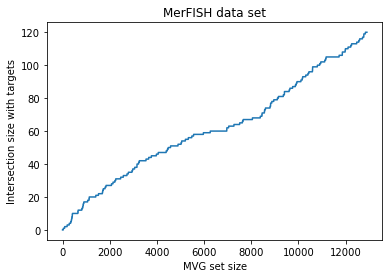

<IPython.core.display.Javascript object>

In [40]:
plot_target_intersection_size(merfish_adata, target_set, title="MerFISH data set")

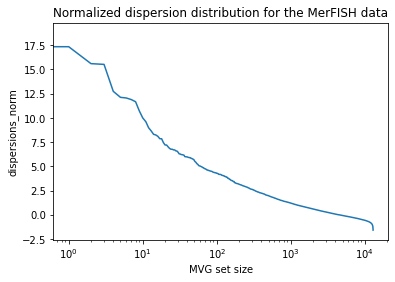

<IPython.core.display.Javascript object>

In [51]:
plot_dispersion_mvg(
    merfish_adata,
    title="Normalized dispersion distribution for the MerFISH data",
    logx=True,
)

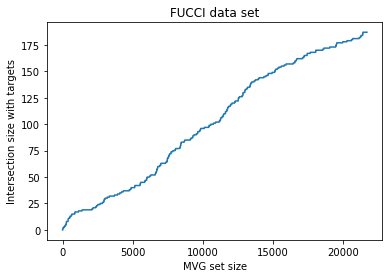

<IPython.core.display.Javascript object>

In [41]:
plot_target_intersection_size(fucci_adata, target_set, title="FUCCI data set")

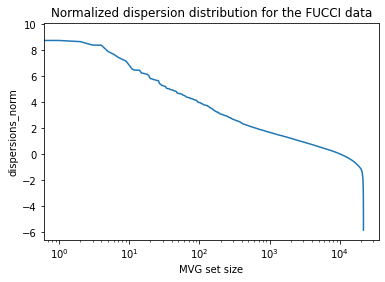

<IPython.core.display.Javascript object>

In [52]:
plot_dispersion_mvg(
    fucci_adata,
    title="Normalized dispersion distribution for the FUCCI data",
    logx=True,
)

We see that the target genes show higher variability in the MerFISH data as the rate of increase of the size of the intersection set is greater. However, as mentioned previously the FUCCI data set covers more of the target genes than the MerFISH one 188/190 vs 125/190. Nonetheless, it is somewhat surprising that the many of the target genes seem to be not variable in both datasets.


### 3d. Comparison of the variable gene sets

To further check the agreement of the two data sets we will now plot the intersection of the sets of the most variable genes for the two data sets for an increasing size of the respective most-variable gene sets.

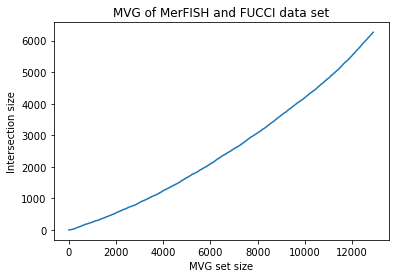

<IPython.core.display.Javascript object>

In [42]:
plot_mvgs_intersection_size(
    merfish_adata, fucci_adata, title="MVG of MerFISH and FUCCI data set"
)

We see that there intersection size seems to be roughly 1/3 of the size of the MVG for this size being smaller than 2'000. This can be explained by the different sample preparation and GEX measuring techniques.

---

## 4. Summary

The previous results can be summarized as follows:
1. The FUCCI data set due its better coverage of gene captures more of the ORF targets 188/190 than the MerFISH data set.
2. The ORF targets do not coincide with the most variable genes for both data sets as for instance to have 50% of the ORF targets (95) included in the most variable gene set of size k, k must be chosen to be roughly 10'000 for both data sets.
3. The two gene expression data sets show an overlap of their most variable genes that increase approx. linearly with a rate of 1/3 for k < 2000.

Thus, if one has to choose potentially the FUCCI data set is more suited simply due to its higher coverage of the ORF targets. The fact, that the ORF targets show only limited variability in both data set can be explained by the fact that those were selected based on a study by Kim et al. (2016) looking at over 5'000 different tumors to identify alleles of genes that are mutated in 27 different cancers. The 220 ORF constructs targeting the 190 different genes are those among the 384 mutated alleles that were found for which an ORF construct existed in the hORF library. As a consequence, those genes while important in cancer in general are a) not guaranteed to be important in osteosarcoma cells and b) might not show large heterogeneity in a cell population of cancer cells.

Finally, we save the two analyzed data sets and the gene target list to disk.

In [35]:
fucci_adata_fname = "../../data/gex/fucci_adata.h5"
fucci_adata.write(fucci_adata_fname)

... storing 'gene_symbol' as categorical


<IPython.core.display.Javascript object>

In [36]:
merfish_adata_fname = "../../data/gex/merfish_adata.h5"
merfish_adata.write(merfish_adata_fname)

<IPython.core.display.Javascript object>

In [37]:
gene_targets = pd.DataFrame(list(target_set), columns=["gene"])
gene_targets.to_csv("../../data/gex/gene_target_list.txt", index=False, header=False)

<IPython.core.display.Javascript object>

---

## Extension: Coverage of morphologically important gene sets

In the following we want to look at the coverage of the FUCCI data set and the iRefIndexDB v14 of genes that were found to be important modulators of the chromatin organization and the nuclear morphology to this end, we will look for now at the respective gene sets corresponding the entries in the Reactome data base R-HSA-8953897.5 and Id: R-HSA-4839726.2.

We will first load the respective gene lists.

In [14]:
stimuli_response_gene_set = pd.read_csv(
    "../../data/gex/reactome_response_to_stimuli.tsv", sep="\t"
)
stimuli_response_gene_set = list(stimuli_response_gene_set.iloc[:, 0])
stimuli_response_gene_set = [item.split(" ")[1] for item in stimuli_response_gene_set]
stimuli_response_gene_set = set(stimuli_response_gene_set)

{'AAAS',
 'ABCC1',
 'ACADVL',
 'ACD',
 'ACTR10',
 'ACTR1A',
 'ADD1',
 'AGO1',
 'AGO3',
 'AGO4',
 'AJUBA',
 'AKT1S1',
 'ALB',
 'ANAPC1',
 'ANAPC10',
 'ANAPC11',
 'ANAPC15',
 'ANAPC16',
 'ANAPC2',
 'ANAPC4',
 'ANAPC5',
 'ANAPC7',
 'APOA1',
 'APOB',
 'AQP8',
 'AR',
 'ARFGAP1',
 'ARNT',
 'ARNTL',
 'ASF1A',
 'ASNS',
 'ATF2',
 'ATF3',
 'ATF4',
 'ATF5',
 'ATF6',
 'ATM',
 'ATOX1',
 'ATP6V0B',
 'ATP6V0C',
 'ATP6V0D1',
 'ATP6V0D2',
 'ATP6V0E1',
 'ATP6V0E2',
 'ATP6V1A',
 'ATP6V1B1',
 'ATP6V1B2',
 'ATP6V1C1',
 'ATP6V1C2',
 'ATP6V1D',
 'ATP6V1E1',
 'ATP6V1E2',
 'ATP6V1F',
 'ATP6V1G1',
 'ATP6V1G2',
 'ATP6V1G3',
 'ATP6V1H',
 'ATP7A',
 'ATR',
 'BACH1',
 'BAG1',
 'BAG2',
 'BAG3',
 'BAG4',
 'BAG5',
 'BLVRA',
 'BLVRB',
 'BMI1',
 'BMT2',
 'C12orf66',
 'CA9',
 'CABIN1',
 'CALR',
 'CAMK2A',
 'CAMK2B',
 'CAMK2D',
 'CAMK2G',
 'CAPZA1',
 'CAPZA2',
 'CAPZA3',
 'CAPZB',
 'CARM1',
 'CASTOR1',
 'CASTOR2',
 'CAT',
 'CBX2',
 'CBX4',
 'CBX6',
 'CBX8',
 'CCAR2',
 'CCL2',
 'CCNA1',
 'CCNA2',
 'CCNE1',
 'CCNE2',
 'CCS',

<IPython.core.display.Javascript object>

In [15]:
chromatin_org_gene_set = pd.read_csv(
    "../../data/gex/reactome_chromatin_organization.tsv", sep="\t"
)
chromatin_org_gene_set = list(chromatin_org_gene_set.iloc[:, 0])
chromatin_org_gene_set = [item.split(" ")[1] for item in chromatin_org_gene_set]
chromatin_org_gene_set = set(chromatin_org_gene_set)

{'ACTB',
 'ACTL6A',
 'ACTL6B',
 'AEBP2',
 'ARID1A',
 'ARID1B',
 'ARID2',
 'ARID4A',
 'ARID4B',
 'ARID5B',
 'ASH1L',
 'ASH2L',
 'ATF2',
 'ATF7IP',
 'ATXN7',
 'ATXN7L3',
 'BRD1',
 'BRD8',
 'BRMS1',
 'BRPF1',
 'BRPF3',
 'BRWD1',
 'CARM1',
 'CCND1',
 'CDK4',
 'CHD3',
 'CHD4',
 'CLOCK',
 'COPRS',
 'CREBBP',
 'DMAP1',
 'DNMT3A',
 'DOT1L',
 'DPY30',
 'DR1',
 'EED',
 'EHMT1',
 'EHMT2',
 'ELP1',
 'ELP2',
 'ELP3',
 'ELP4',
 'ELP5',
 'ELP6',
 'ENY2',
 'EP300',
 'EP400',
 'EPC1',
 'EZH2',
 'GATAD2A',
 'GATAD2B',
 'GPS2',
 'H2AB1',
 'H2AC1',
 'H2AC11',
 'H2AC12',
 'H2AC14',
 'H2AC18',
 'H2AC20',
 'H2AC21',
 'H2AC4',
 'H2AC6',
 'H2AC7',
 'H2AJ',
 'H2AW',
 'H2AX',
 'H2AZ1',
 'H2AZ2',
 'H2BC1',
 'H2BC11',
 'H2BC12',
 'H2BC13',
 'H2BC14',
 'H2BC15',
 'H2BC17',
 'H2BC18',
 'H2BC21',
 'H2BC3',
 'H2BC4',
 'H2BC5',
 'H2BC9',
 'H2BU1',
 'H3C1',
 'H3C15',
 'H4C1',
 'HAT1',
 'HCFC1',
 'HDAC1',
 'HDAC10',
 'HDAC2',
 'HDAC3',
 'HDAC8',
 'HMG20B',
 'ING3',
 'ING4',
 'ING5',
 'JADE1',
 'JADE2',
 'JADE3',
 'JAK2',

<IPython.core.display.Javascript object>

In [17]:
venn.venn5({"iRefIndexDB v14":})

  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=1b43659a45b3033e52399a3aa8a29c0e33efb1b62f3a981f663fc3b60d26947d
  Stored in directory: /home/paysan_d/.cache/pip/wheels/24/25/51/e88b9ad98643aa2c27f01a9bf5ccd10b7239e7535135d3feb1
Successfully built venn


<IPython.core.display.Javascript object>